In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as stats
import statsmodels.api as sm
import matplotlib.patches as mpatches

from scipy import stats
from IPython.display import Image
from statsmodels.formula.api import ols
from statsmodels.stats.anova import anova_lm
from graphviz import Digraph
from matplotlib.collections import PatchCollection

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Helper Functions

In [3]:
# Define some helper functions
class Node():

    def __init__(
        self, center, radius, label,
        facecolor='#2653de', edgecolor='#e6e6e6',
        ring_facecolor='#a3a3a3', ring_edgecolor='#a3a3a3',
        **kwargs
        ):
        """
        Initializes a Markov Chain Node(for drawing purposes)
        Inputs:
            - center : Node (x,y) center
            - radius : Node radius
            - label  : Node label
        """
        self.center = center
        self.radius = radius
        self.label  = label

        # For convinience: x, y coordinates of the center
        self.x = center[0]
        self.y = center[1]

        # Drawing config
        self.node_facecolor = facecolor
        self.node_edgecolor = edgecolor

        self.ring_facecolor = ring_facecolor
        self.ring_edgecolor = ring_edgecolor
        self.ring_width = 0.03

        self.text_args = {
            'ha': 'center',
            'va': 'center',
            'fontsize': kwargs.get("node_fontsize", 12)
        }


    def add_circle(self, ax):
        """
        Add the annotated circle for the node
        """
        circle = mpatches.Circle(self.center, self.radius)
        p = PatchCollection(
            [circle],
            edgecolor = self.node_edgecolor,
            facecolor = self.node_facecolor
        )
        ax.add_collection(p)
        ax.annotate(
            self.label,
            xy = self.center,
            color = '#ffffff',
            **self.text_args
        )


    def add_self_loop(self, ax, prob=None, direction='up', annotate = True, percentages = False):
        """
        Draws a self loop
        """
        if direction == 'up':
            start = -30
            angle = 180
            ring_x = self.x
            ring_y = self.y + self.radius
            prob_y = self.y + 1.3*self.radius
            x_cent = ring_x - self.radius + (self.ring_width/2)
            y_cent = ring_y - 0.15
        else:
            start = -210
            angle = 0
            ring_x = self.x
            ring_y = self.y - self.radius
            prob_y = self.y - 1.4*self.radius
            x_cent = ring_x + self.radius - (self.ring_width/2)
            y_cent = ring_y + 0.15

        # Add the ring
        ring = mpatches.Wedge(
            (ring_x, ring_y),
            self.radius,
            start,
            angle,
            width = self.ring_width
        )
        # Add the triangle (arrow)
        offset = 0.2
        left   = [x_cent - offset, ring_y]
        right  = [x_cent + offset, ring_y]
        bottom = [(left[0]+right[0])/2., y_cent]
        arrow  = plt.Polygon([left, right, bottom, left])

        p = PatchCollection(
            [ring, arrow],
            edgecolor = self.ring_edgecolor,
            facecolor = self.ring_facecolor
        )
        ax.add_collection(p)

        # Probability to add?
        if prob and annotate:
            text = f"{prob*100 if percentages else prob:.1f}".rstrip("0").rstrip(".")
            text += "%" if percentages else ""
            ax.annotate(text, xy=(self.x, prob_y), color='#000000', **self.text_args)


class MarkovChain:

    def __init__(self, M, labels, **kwargs):
        """
        Initializes a Markov Chain (for drawing purposes)
        Inputs:
            - M         Transition Matrix
            - labels    State Labels
            - kwargs    Keywords to modify how data is displayed, specifically:
                        annotate          if False, probabilities aren't shown
                        arrow_edgecolor
                        arrow_facecolor
                        arrow_head_width
                        arrow_width
                        fontsize          affects transition probability labels
                        node_edgecolor
                        node_facecolor
                        node_fontsize     affects node labels
                        node_radius
                        percentages       bool, if True probabilites should be
                                          displayed as percentages instead of decimals
                        transparency_func function to determine transparency of arrows (default: alpha = prob)
        """

        np.set_printoptions(precision=3,suppress=True)

        if M.shape[0] < 2:
            raise Exception("There should be at least 2 states")
        if M.shape[0] != M.shape[1]:
            raise Exception("Transition matrix should be square")
        if M.shape[0] != len(labels):
            raise Exception("There should be as many labels as states")

        # save args
        self.M = M
        self.n_states = M.shape[0]
        self.labels = labels

        self.save_kwargs(**kwargs)

        # Build the network
        self.build_network()


    def save_kwargs(self, **kwargs):

        # save the dictionary
        self.kwargs = kwargs

        # Colors
        self.arrow_facecolor = self.kwargs.get("arrow_facecolor", '#a3a3a3')
        self.arrow_edgecolor = self.kwargs.get("arrow_edgecolor", '#a3a3a3')
        self.node_facecolor = self.kwargs.get("node_facecolor", '#2693de')
        self.node_edgecolor = self.kwargs.get("node_edgecolor", '#e6e6e6')

        # Drawing config
        self.node_radius = self.kwargs.get("node_radius", 0.60)
        self.arrow_width = self.kwargs.get("arrow_width", 0.1)
        self.arrow_head_width = self.kwargs.get("arrow_head_width", 0.22)
        self.text_args = {
            'ha': 'center',
            'va': 'center',
            'fontsize': self.kwargs.get("fontsize", 14)
        }

        # How to represent the probabilities
        self.percentages = self.kwargs.get("percentages", False)
        self.annotate_probabilities = self.kwargs.get("annotate", True)
        self.transparency_func = self.kwargs.get("transparency_func", lambda p: p)


    def set_node_centers(self):
        """
            Spread the nodes evenly around in a circle using Euler's formula
            e^(2pi*i*k/n), where n is the number of nodes and k is the
            index over which we iterate. The real part is the x coordinate,
            the imaginary part is the y coordinate. Then scale by n for more room.

            self.node_centers is a numpy array of shape (n,2)
        """

        # For legibility, we use n below
        n = self.n_states

        # generate the evenly spaced coords on the unit circle
        unit_circle_coords = np.fromfunction(lambda x,y:
                        (1-y)*np.real(np.exp(2 * np.pi * x/n * 1j))
                        + y * np.imag(np.exp(2 * np.pi * x/n * 1j)),
                        (n,2))

        self.figsize = (n*2+2, n*2+2)
        self.xlim = (-n-1, n+1)
        self.ylim = (-n-1, n+1)

        # Scale by n to have more room
        self.node_centers = unit_circle_coords * n


    def build_network(self):
        """
        Loops through the matrix, add the nodes
        """
        # Position the node centers
        self.set_node_centers()

        # Set the nodes
        self.nodes = [Node(self.node_centers[i],
                           self.node_radius,
                           self.labels[i],
                           **self.kwargs) for i in range(self.n_states)]


    def add_arrow(self, ax,
                  node1, node2,
                  prob=None, width=None,
                  head_width=None,
                  annotate = True,
                  arrow_spacing = 0.15,
                  transparency_func = None):
        """
        Add a directed arrow between two nodes

        Keywords:

        annotate:                if True, probability is displayed on top of the arrow
        arrow_spacing:           determines space between arrows in opposite directions
        head_width:              width of arrow head
        prob:                    probability of going from node1 to node2
        transparency_func:       function to determine transparency of arrows
        width:                   width of arrow body
        """

        if width is None:
            width = self.arrow_width
        if head_width is None:
            head_width = self.arrow_head_width
        if transparency_func is None:
            transparency_func = self.transparency_func

        # x,y start of the arrow, just touching the starting node
        x_start = node1.x + node1.radius*(node2.x-node1.x)/np.linalg.norm(node2.center-node1.center)
        y_start = node1.y + node1.radius*(node2.y-node1.y)/np.linalg.norm(node2.center-node1.center)

        # find the arrow length so it just touches the ending node
        dx = node2.x-x_start - node2.radius*(node2.x-node1.x)/np.linalg.norm(node2.center-node1.center)
        dy = node2.y-y_start - node2.radius*(node2.y-node1.y)/np.linalg.norm(node2.center-node1.center)

        # calculate offset so arrows in opposite directions are separate

        x_offset = dy / np.sqrt(dx**2+dy**2) * arrow_spacing
        y_offset = -dx / np.sqrt(dx**2+dy**2) * arrow_spacing

        arrow = mpatches.FancyArrow(
            x_start + x_offset,
            y_start + y_offset,
            dx,
            dy,
            width = width,
            head_width = head_width,
            length_includes_head = True
        )
        p = PatchCollection(
            [arrow],
            edgecolor = self.arrow_edgecolor,
            facecolor = self.arrow_facecolor,
            alpha = transparency_func(prob)
        )
        ax.add_collection(p)

        # Add label of probability at coordinates (x_prob, y_prob)
        x_prob = x_start +  0.2*dx + 1.2 * x_offset
        y_prob = y_start +  0.2*dy + 1.2 * y_offset
        if prob and annotate:
            text = f"{prob*100 if self.percentages else prob:.2f}".rstrip("0").rstrip(".")
            text += "%" if self.percentages else ""
            ax.annotate(text, xy=(x_prob, y_prob), color='#000000', **self.text_args)


    def draw(self, img_path=None):
        """
        Draw the Markov Chain
        """
        fig, ax = plt.subplots(figsize=self.figsize)

        # Set the axis limits
        plt.xlim(self.xlim)
        plt.ylim(self.ylim)

        # Draw the nodes
        for node in self.nodes:
            node.add_circle(ax)

        # Add the transitions
        for i in range(self.M.shape[0]):
            for j in range(self.M.shape[1]):
                # self loops
                if i == j and self.M[i,i] > 0:
                    self.nodes[i].add_self_loop(ax,
                                                prob = self.M[i,j],
                                                direction = 'up' if self.nodes[i].y >= 0 else 'down',
                                                annotate = self.annotate_probabilities,
                                                percentages = self.percentages)

                # directed arrows
                elif self.M[i,j] > 0:
                    self.add_arrow(ax,
                                   self.nodes[i],
                                   self.nodes[j],
                                   prob = self.M[i,j],
                                   annotate = self.annotate_probabilities)

        plt.axis('off')
        # Save the image to disk?
        if img_path:
            plt.savefig(img_path)
        plt.show()

In [4]:
# Define transition counting matrix
def get_transition_tuples(ls):
    ''' Converts a list into a list of transition tuples
    '''
    return [(ls[i-1], ls[i]) for i in range(1, len(ls))]

# Define functions to visualize transition matrices as graphs
def get_df_edgelist(df, ls_index):
    ''' Derive an edge list with weight values
    '''
    edgelist = []
    for i in ls_index:
        for j in ls_index:
            edgelist.append([i, j, df[j][i]])
    return pd.DataFrame(edgelist, columns=['src', 'dst', 'weight'])

def edgelist_to_digraph(df_edgelist):
    ''' Convert an edge list into a weighted directed graph
    '''
    g = Digraph(format='jpeg')
    g.attr(rankdir='LR', size='30')
    g.attr('node', shape='circle')
    nodelist = []
    for _, row in df_edgelist.iterrows():
        node1, node2, weight = [str(item) for item in row]
        if node1 not in nodelist:
            g.node(node1, **{'width': '1', 'height': '1'})
            nodelist.append(node1)
        if node2 not in nodelist:
            g.node(node2, **{'width': '1', 'height': '1'})
            nodelist.append(node2)
        g.edge(node1, node2, label=weight)
    return g

def render_graph(fname, df, ls_index):
    ''' Render a visual graph and saves it to disk
    '''
    df_edgelist = get_df_edgelist(df, ls_index)
    g = edgelist_to_digraph(df_edgelist)
    g.render(fname, view=True)

def sim_steps(transition_prob, steps, initial_prob):
    ''' simulating a markov chain using DataFrame transition prob matrix
    '''
    transition_prob = np.asarray(transition_prob)
    simlist = np.zeros(steps, dtype=int)            # vector of integer zeros
    state_space = np.arange(0, transition_prob.shape[0])  # state space based on transition matrix shape
    simlist[0] = np.random.choice(state_space, p=initial_prob) # simulate 1st unit

    for i in range(1,steps):
      pk = np.asarray(transition_prob[simlist[i-1],])   # go to simulated state
      simlist[i] = np.random.choice(state_space, p=pk)  # simulate next unit

    return simlist

In [20]:
def draw_court():
    fig, ax = plt.subplots(figsize=(10, 8))

    # Court dimensions in feet
    court_length = 20
    court_width = 10

    # Draw the outer court
    court = mpatches.Rectangle((0, 0), court_length, court_width, linewidth=2, edgecolor="black", facecolor="#993300")
    ax.add_patch(court)

    # Draw the net
    net = mpatches.ConnectionPatch((court_length/2, 0-2),
     (court_length/2, court_width+2), "data", "data", linewidth=2, color="white", linestyle="dashed")
    ax.add_patch(net)

    # Set axis limits and labels
    ax.set_xlim(0-5, court_length+5)
    ax.set_ylim(0-5, court_width+5)
    ax.set_aspect("equal")
    ax.axis("off")

    return fig, ax

# (0) Pick a sport
    Volleyball

# (A) Markov Model

In [7]:
states = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15,
          16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29]

states_names = ["Serve (N)", "Serve (T)", "Dig (N)", "Dig (T)",
                "Tip (N)", "Tip (T)", "Set (N)", "Set (T)",
                "Free Ball (N)", "Free Ball (T)", "Ace (N)", "Ace (T)",
                "Kill (N)", "Kill (T)", "Block (N)", "Block (T)",
                "Out of Bounds (N)", "Out of Bounds (T)",
                "Back Row Attack (N)", "Back Row Attack (T)",
                "Outside Attack (N)", "Outside Attack (T)",
                "Middle Attack (N)", "Middle Attack (T)",
                "Right Attack (N)", "Right Attack (T)",
                "Net Violation (N)", "Net Violation (T)",
                "Point (N)", "Point (T)"]

In [13]:
Pxy = np.array([
        [0, 0, 0, 17/22, 0, 0, 0, 0, 0, 0, 1/11, 0, 0, 0, 0, 0, 3/22, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],     #From Serve (N)
        [0, 0, 17/24, 0, 0, 0, 0, 0, 0, 0, 0, 3/24, 0, 0, 0, 0, 0, 4/24, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],     #From Serve (T)
        [0, 0, 0, 0, 4/38, 0, 32/38, 0, 1/38, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1/38, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],  #From Dig (N)
        [0, 0, 0, 0, 0, 1/42, 0, 40/42, 0, 1/42, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],     #From Dig (T)
        [0, 0, 0, 1/2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1/6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1/3, 0],         #From Tip (N)
        [0, 0, 2/5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1/5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2/5],         #From Tip (T)
        [0, 0, 0, 0, 3/29, 0, 0, 0, 1/29, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1/29, 0, 14/29, 0, 4/29, 0, 6/29, 0, 0, 0, 0, 0], #From Set (N)
        [0, 0, 0, 0, 0, 3/38, 0, 0, 0, 2/38, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2/38, 0, 20/38, 0, 4/38, 0, 7/38, 0, 0, 0, 0], #From Set (T)
        [0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],               #From Free Ball (N)
        [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],               #From Free Ball (T)
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0],               #From Ace (N)
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1],               #From Ace (T)
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0],               #From Kill (N)
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1],               #From Kill (T)
        [0, 0, 0, 3/7, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4/7, 0],           #From Block (N)
        [0, 0, 1/5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4/5],           #From Block (T)
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1],               #From Out of Bounds (N)
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0],               #From Out of Bounds (T)
        [0, 0, 0, 1/2, 0, 0, 0, 0, 0, 0, 0, 0, 1/2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],           #From Back Row Attack (N)
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1/2, 1/2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],           #From Back Row Attack(T)
        [0, 0, 0, 6/14, 0, 0, 0, 0, 0, 0, 0, 0, 3/14, 0, 0, 3/14, 2/14, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],   #From Outside Attack (N)
        [0, 0, 8/20, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 7/20, 2/20, 0, 0, 2/20, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1/20, 0, 0],#From Outside Attack (T)
        [0, 0, 0, 1/2, 0, 0, 0, 0, 0, 0, 0, 0, 1/4, 0, 0, 1/4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],         #From Middle Attack (N)
        [0, 0, 1/2, 0, 0, 0, 0, 0, 0, 0, 0, 1/2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],               #From Middle Attack (T)
        [0, 0, 0, 1/3, 0, 0, 0, 0, 0, 0, 0, 0, 1/2, 0, 0, 0, 1/6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],         #From Right Attack (N)
        [0, 0, 4/7, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1/7, 1/7, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1/7, 0, 0],       #From Right Attack (T)
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1],               #From Net Violation (N)
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0],               #From Net Violation (T)
        [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],               #From Point (N)
        [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],               #From Point (T)
        ])

In [9]:
mc = MarkovChain(Pxy, states_names)
mc.draw()

Output hidden; open in https://colab.research.google.com to view.

# (B) Simulate Ball Transition

In [28]:
initial_prob = Pxy[0,:]
sims = sim_steps(Pxy, 100, initial_prob)
print(sims)

[ 3  7 25  2  6 22  3  7  9  2  6 20 16 29  1  2  6 20  3  7  5  2  6 20
 15  2  6 24 16 29  1  2  6 24  3  7 21  2  4 28  0 16 29  1 17 28  0  3
  7 21 27 28  0  3  7 21  2  4 28  0 16 29  1  2  6  4  3  7 21  2  6 20
 15 29  1  2  6 20 16 29  1 17 28  0  3  7 21 17 28  0  3  7 25 27 28  0
 16 29  1 17]


# (C) Simulate Ball Coordinates

In [29]:
coords = np.array([[0, 8], [20, 2], [2, 3], [18, 7],
                   [8, 6], [12, 4], [6, 4], [14, 6],
                   [5, 5], [15, 5], [7, 5], [13, 5],
                   [9, 4], [11, 6], [9.5, 5], [10.5, 5],
                   [-2, 4], [22, 6],
                   [1, 3], [19, 7],
                   [5, 2], [15, 8],
                   [4, 5], [16, 5],
                   [7, 1], [13, 9],
                   [10, 5], [10, 5],
                   [3, 8], [17, 2]])

In [30]:
dff = pd.DataFrame(coords[sims], columns=['x','y'])
dff['end_x'] = dff['x'].shift(1)
dff['end_y'] = dff['y'].shift(1)
dff.tail(3)

,x,y,end_x,end_y
97,17.0,2.0,-2.0,4.0
98,20.0,2.0,17.0,2.0
99,22.0,6.0,20.0,2.0


# (D) Simulate Team Switch

In [31]:
T_to_N = 0
for i in range(1, len(sims)):
    if sims[i-1] % 2 == 0 and sims[i] % 2 != 0:
        T_to_N += 1
print("Number of times the ball switched teams from Texas to Nebraska:", T_to_N)

N_to_T = 0
for i in range(1, len(sims)):
    if sims[i-1] % 2 != 0 and sims[i] % 2 == 0:
        N_to_T += 1
print("Number of times the ball switched teams from Nebraska to Texas:", N_to_T)

N_points = 0
for i in range(1, len(sims)):
    if sims[i] == 28:
        N_points += 1
print("\nNumber of points scored by Nebraska:", N_points)

T_points = 0
for i in range(1, len(sims)):
    if sims[i] == 29:
        T_points += 1
print("Number of points scored by Texas:", T_points)

Number of times the ball switched teams from Texas to Nebraska: 16
Number of times the ball switched teams from Nebraska to Texas: 16

Number of points scored by Nebraska: 7
Number of points scored by Texas: 7


# (E) Visualize Performance

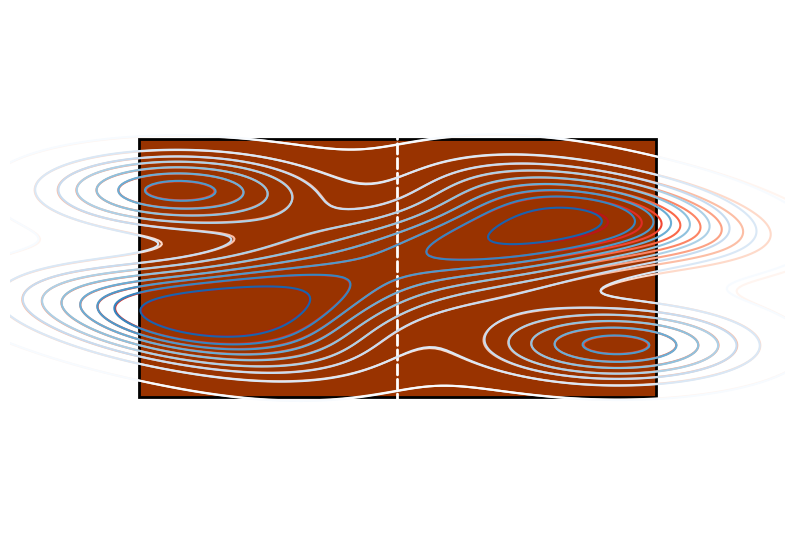

In [32]:
fig, ax = draw_court()
sns.kdeplot(x=dff['x'], y=dff['y'], cmap='Reds', fill=False, ax=ax)
sns.kdeplot(x=dff['end_x'], y=dff['end_y'], cmap='Blues', fill=False, ax=ax)
plt.show()

In [22]:
!pip install statsbombpy mplsoccer

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.7/63.7 kB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.8/85.8 kB 5.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.4/61.4 kB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.4/66.4 kB 4.8 MB/s eta 0:00:00


In [23]:
from statsbombpy import sb
from graphviz import Digraph
from matplotlib.collections import PatchCollection
from mplsoccer import Pitch, VerticalPitch
from matplotlib.lines import Line2D

Text(0.5, 1.0, 'Nebraska vs. Texas\n2023 NCAA Volleyball Championship')

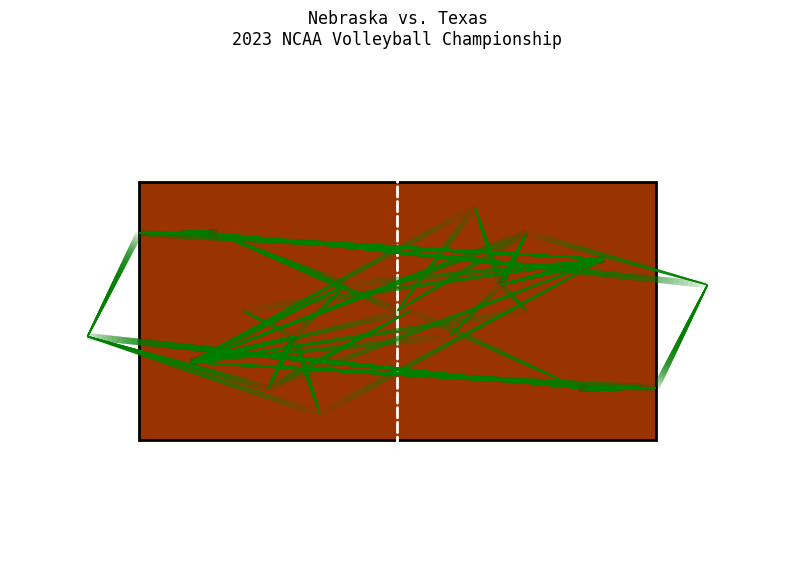

In [33]:
fig, ax = draw_court()
pitch = Pitch(pitch_type='statsbomb')
pitch.lines(dff['x'], dff['y'], dff['end_x'], dff['end_y'], lw=5, transparent=True, comet=True, ax=ax, color='g')
ax.set_title("Nebraska vs. Texas\n2023 NCAA Volleyball Championship", fontsize=12, fontfamily='monospace')